<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/simdkalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ■ Overview
- simdkalmanライブラリを使ってみる。
- データセットは乱数とGPSデータの2種類。
- フィルタとしてではなく、平滑化として使ってみる。

## ■ Reference
- [oseiskar/simdkalman/examples/multi_dimensional_observations.py](https://github.com/oseiskar/simdkalman/blob/139183f9f806349538710bf73b8955ae3d433a3f/examples/multi_dimensional_observations.py)
- [GPS Trajectories Data Set | UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/GPS+Trajectories)

## ■ Install & Import

In [1]:
!pip install simdkalman

In [2]:
import simdkalman
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import pandas as pd

## ■ Preparation

In [3]:
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

# simulate 100 random walk time series
rand = lambda: random.normal(size=(100, 200))
data = np.cumsum(np.cumsum(rand()*0.02, axis=1) + rand(), axis=1) + rand()*3

# introduce 10% of NaNs denoting missing values
data[random.uniform(size=data.shape) < 0.1] = np.nan

## ■ Excecute
### Random dataset

In [4]:
# fit noise parameters to data with the EM algorithm (optional)
kf = kf.em(data, n_iter=10)

# smooth and explain existing data
smoothed = kf.smooth(data)
# predict new data
pred = kf.predict(data, 15)
# could be also written as
# r = kf.compute(data, 15); smoothed = r.smoothed; pred = r.predicted

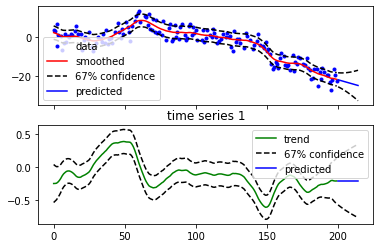

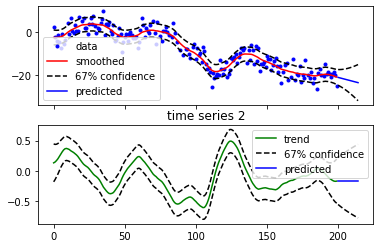

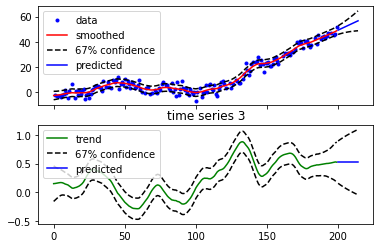

In [5]:
# show the first 3 smoothed time series
for i in range(3):

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.title("time series %d" % (i+1))

    x = np.arange(0, data.shape[1])

    ax1.plot(x, data[i,:], 'b.', label="data")

    smoothed_obs = smoothed.observations.mean[i,:]
    obs_stdev = np.sqrt(smoothed.observations.cov[i,:])
    ax1.plot(x, smoothed_obs, 'r-', label="smoothed")
    ax1.plot(x, smoothed_obs - obs_stdev, 'k--', label="67% confidence")
    ax1.plot(x, smoothed_obs + obs_stdev, 'k--')

    x_pred = np.arange(data.shape[1], data.shape[1]+pred.observations.mean.shape[1])
    y_pred = pred.observations.mean[i,:]
    pred_stdev = np.sqrt(pred.observations.cov[i,:])
    ax1.plot(x_pred, y_pred, 'b-', label="predicted")
    ax1.plot(x_pred, y_pred + pred_stdev, 'k--')
    ax1.plot(x_pred, y_pred - pred_stdev, 'k--')
    ax1.legend()

    trend = smoothed.states.mean[i,:,1]
    trend_stdev = np.sqrt(smoothed.states.cov[i,:,1,1])
    ax2.plot(x, trend, 'g-', label="trend")
    ax2.plot(x, trend - trend_stdev, 'k--', label="67% confidence")
    ax2.plot(x, trend + trend_stdev, 'k--')

    trend_pred = pred.states.mean[i,:,1]
    trend_pred_stdev = np.sqrt(pred.states.cov[i,:,1,1])
    ax2.plot(x_pred, trend_pred, 'b-', label='predicted')
    ax2.plot(x_pred, trend_pred + trend_pred_stdev, 'k--')
    ax2.plot(x_pred, trend_pred - trend_pred_stdev, 'k--')
    ax2.legend()

    plt.show()

### GPS trajectory dataset

In [6]:
# Machine learning repository から位置情報データセットをダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00354/GPS%20Trajectory.rar  \
    -O gps_trajectory.rar
# 解凍
!unrar e gps_trajectory.rar gps_trajectory/

--2021-06-10 14:28:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00354/GPS%20Trajectory.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220690 (216K) [application/x-httpd-php]
Saving to: ‘gps_trajectory.rar’

gps_trajectory.rar  100%[===================>] 215.52K   840KB/s    in 0.3s    

2021-06-10 14:28:06 (840 KB/s) - ‘gps_trajectory.rar’ saved [220690/220690]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from gps_trajectory.rar

Creating    gps_trajectory                                            OK
Extracting  gps_trajectory/go_track_tracks.csv                             1%  OK 
Extracting  gps_trajectory/go_track_trackspoints.csv                      16% 31% 46% 61% 76% 90% 99%  OK 
All OK


In [7]:
trackpoints = pd.read_csv('/content/gps_trajectory/go_track_trackspoints.csv')
print(trackpoints.shape)

(18107, 5)


In [8]:
display(trackpoints.head())

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


In [9]:
# track_id の行数カウント
trackpoints.groupby('track_id').size().sort_values(ascending=False)[:10]

track_id
30       646
31       646
41       433
37962    410
27       401
26       401
38017    393
38002    385
132      356
131      317
dtype: int64

In [16]:
import plotly.express as px

# "track_id"カラムを"label"に変更
# df = trackpoints.rename(columns={'track_id': 'label'})
df = trackpoints.drop('track_id', axis=1)
df['label'] = trackpoints['track_id'].rank(method='dense')

# 位置情報の中心を計算
center = {'lat': trackpoints['latitude'].mean(), 
          'lon': trackpoints['longitude'].mean()}

# 地図に描画
fig = px.scatter_mapbox(
    df,                    
    # 緯度経度カラムを指定
    lat="latitude",
    lon="longitude",
    # 色ラベルのカラムを指定
    color="label",
    labels="label",
    zoom=8,
    center=center,
    height=600,
    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

In [ ]:
# track_id=30だけ描画
trackid30_df = trackpoints[trackpoints['track_id']==30].rename(columns={'track_id': 'label'})
lat = trackid30_df['latitude'].mean()
lng = trackid30_df['longitude'].mean()
center = {'lat':lat, 'lon':lng}

fig = px.scatter_mapbox(
    trackid30_df,                    
    lat="latitude",
    lon="longitude",
    color="label",
    labels="label",
    zoom=9,
    center=center,
    height=600,
    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

In [ ]:
# track_id=30を抽出
observed_df = trackpoints[trackpoints['track_id']==30][['latitude', 'longitude']]
observed_df['label'] = 'observed'

# simdkalmanを定義
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

# 
kf = kf.em(observed_df[['latitude', 'longitude']], n_iter=20)
smoothed = kf.smooth(observed_df[['latitude', 'longitude']])

In [ ]:
smoothed_df = pd.DataFrame(smoothed.observations.mean, columns=['latitude', 'longitude'])
smoothed_df['label'] = 'smoothed'
tmp_df = pd.concat([observed_df, smoothed_df])

lat = tmp_df['latitude'].mean()
lng = tmp_df['longitude'].mean()
center = {'lat':lat, 'lon':lng}

fig = px.scatter_mapbox(
    tmp_df,                    
    # Here, plotly gets, (x,y) coordinates
    lat="latitude",
    lon="longitude",
    #Here, plotly detects color of series
    color="label",
    labels="label",
    zoom=10,
    center=center,
    height=600,
    width=800)

fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()